In [1]:
import torchaudio
import numpy as np
train_dataset = torchaudio.datasets.VoxCeleb1Identification('/mnt/d/VoxCeleb1Identification/data', subset='train', download=False)
test_dataset = torchaudio.datasets.VoxCeleb1Identification('/mnt/d/VoxCeleb1Identification/data', subset='test', download=False)

In [2]:


# present_train_audio_files = []
# missing_train_audio_files = []
# sub_train_len = len(train_dataset) #4000
# for i in range(sub_train_len):
#   try:
#     train_dataset[i][2]
#     present_train_audio_files.append(i)
#   except:
#     missing_train_audio_files.append(i)

# present_test_audio_files = []
# missing_test_audio_files = []
# sub_test_len = len(test_dataset) #200
# for i in range(sub_test_len):
#   try:
#     test_dataset[i][2]
#     present_test_audio_files.append(i)
#   except:
#     missing_test_audio_files.append(i) 

In [3]:
import json
# json.dump(present_train_audio_files, open("present_train_audio_files.json", 'w'))
# json.dump(present_test_audio_files, open("present_test_audio_files.json", 'w'))
present_train_audio_files = json.load(open("present_train_audio_files.json", 'r'))
present_test_audio_files = json.load(open("present_test_audio_files.json", 'r'))

There are 4361 missing files in train dataset and 279 missing files in test dataset. Lets remove those samples.

In [4]:
from torch.utils.data import Subset
from torch.utils.data import Dataset
import torch

class VoxCeleb1IdentificationUnified(Dataset):
    
    def __init__(self, voxceleb1_dataset, present_audio_files = []):
        self.voxceleb1_dataset = voxceleb1_dataset
        self.voxceleb1_dataset = Subset(self.voxceleb1_dataset, present_audio_files)
        
        self.num_samples_per_clip = 40000   
        self.mel_spectrogram_transformation = torchaudio.transforms.MelSpectrogram(
            sample_rate=4000,
            n_fft=1024,
            hop_length=512,
            n_mels=64)

    def __getitem__(self, idx):
        waveform, _, target, _ = self.voxceleb1_dataset[idx]
        waveform = torchaudio.transforms.Resample(16000, 4000)(waveform)
        waveform = self._right_zero_pad(self._cut_if_necessary(waveform))
        mel_spec = self.mel_spectrogram_transformation(waveform)
        return mel_spec, target
    
    def __len__(self):
        return len(self.voxceleb1_dataset)
    
    def _right_zero_pad(self, signal):
      length_signal = signal.shape[1]
      if length_signal < self.num_samples_per_clip:
          num_missing_samples = self.num_samples_per_clip - length_signal
          signal = torch.nn.functional.pad(signal, (0, num_missing_samples))
      return signal
    
    def _cut_if_necessary(self, signal):
      if signal.shape[1] > self.num_samples_per_clip:
          signal = signal[:, :self.num_samples_per_clip]
      return signal
  
train_subset = VoxCeleb1IdentificationUnified(train_dataset, present_train_audio_files[:10000])
test_subset = VoxCeleb1IdentificationUnified(train_dataset, present_test_audio_files[:1024])

In [5]:
idx = np.random.randint(0, 100)
print(idx)
print(f'train: {train_subset[idx][0].shape}')
print(f'test: {test_subset[idx]}')

59
train: torch.Size([1, 64, 79])
test: (tensor([[[1.7551e-02, 1.2994e-03, 4.3368e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.5096e-02, 3.6462e-02, 1.1672e-02,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.0822e+00, 1.1314e+00, 4.9844e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [3.6695e-03, 2.1206e-02, 1.0555e-02,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [3.8584e-03, 1.7765e-03, 8.6510e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [8.5010e-03, 1.1085e-02, 8.9441e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]]), 2)


In [6]:
print(f'Length of train dataset: {len(train_subset)}')
# print(train_subset[0])
print(' ')
print(f'Length of test dataset: {len(test_subset)}')
# print(test_subset[0])

speakers_test = [test_subset[i][1] for i in range(len(test_subset))]
print(' ')
print(f'There are {len(set(speakers_test))} unique speakers in first {len(test_subset)} samples of test set')

speakers_train = [train_subset[i][1] for i in range(len(train_subset))]
print(' ')
print(f'There are {len(set(speakers_train))} unique speakers in first {len(train_subset)} samples of train set')

Length of train dataset: 10000
 
Length of test dataset: 1024
 
There are 12 unique speakers in first 1024 samples of test set
 
There are 94 unique speakers in first 10000 samples of train set


In [7]:
from torch.optim import lr_scheduler
import torch.optim as optim

cuda = torch.cuda.is_available()

import matplotlib.pyplot as plt

test_speakers_classes = [str(i) for i in range(len(set(speakers_test)))]

# Prepare dataset classes

In [8]:
class TripletVoxCeleb1ID(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, voxceleb1_dataset, train=True):
        self.voxceleb1_dataset = voxceleb1_dataset
        self.train = train
        # self.mel_spectrogram_transformation = torchaudio.transforms.MelSpectrogram(
        #     sample_rate=4000,
        #     n_fft=1024,
        #     hop_length=512,
        #     n_mels=64)
        # self.num_samples_per_clip = 20000 # 5 sec

        if self.train:
            self.train_labels = torch.tensor([self.voxceleb1_dataset[i][1]
                                              for i in range(len(self.voxceleb1_dataset))])
            
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = torch.tensor([self.voxceleb1_dataset[i][1] 
                                              for i in range(len(self.voxceleb1_dataset))])
        
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_labels))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            # audio1, label1 = self._right_zero_pad(self._cut_if_necessary(self.voxceleb1_dataset[index][0])), self.train_labels[index].item()
            audio1, label1 = self.voxceleb1_dataset[index][0], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
                #! 99% that for one particular speaker there is just 1 recording 
                #TODO Create histogram of number of samples assigned to one speaker
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            # audio2 = self._right_zero_pad(self._cut_if_necessary(self.voxceleb1_dataset[positive_index][0]))
            # audio3 = self._right_zero_pad(self._cut_if_necessary(self.voxceleb1_dataset[negative_index][0]))
            audio2 = self.voxceleb1_dataset[positive_index][0]
            audio3 = self.voxceleb1_dataset[negative_index][0]
        else:
            # audio1 = self._right_zero_pad(self._cut_if_necessary(self.voxceleb1_dataset[self.test_triplets[index][0]][0]))
            # audio2 = self._right_zero_pad(self._cut_if_necessary(self.voxceleb1_dataset[self.test_triplets[index][1]][0]))
            # audio3 = self._right_zero_pad(self._cut_if_necessary(self.voxceleb1_dataset[self.test_triplets[index][2]][0]))
            audio1 = self.voxceleb1_dataset[self.test_triplets[index][0]][0]
            audio2 = self.voxceleb1_dataset[self.test_triplets[index][1]][0]
            audio3 = self.voxceleb1_dataset[self.test_triplets[index][2]][0]
                                          
        # spec1 = self.mel_spectrogram_transformation(audio1)
        # spec2 = self.mel_spectrogram_transformation(audio2)
        # spec3 = self.mel_spectrogram_transformation(audio3)   
        spec1 = audio1
        spec2 = audio2
        spec3 = audio3 

        return (spec1, spec2, spec3), []

    def __len__(self):
        return len(self.voxceleb1_dataset)

In [9]:
triplet_dataset_train = TripletVoxCeleb1ID(train_subset, train=True)
print(triplet_dataset_train[0][0][0])
triplet_dataset_test = TripletVoxCeleb1ID(test_subset, train=False)
print(triplet_dataset_test.label_to_indices)

tensor([[[0.0950, 0.0335, 0.0317,  ..., 0.0000, 0.0000, 0.0000],
         [0.2633, 0.0710, 0.1347,  ..., 0.0000, 0.0000, 0.0000],
         [0.2061, 0.2481, 0.4476,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4310, 0.2828, 0.6234,  ..., 0.0000, 0.0000, 0.0000],
         [0.1225, 0.3323, 0.6438,  ..., 0.0000, 0.0000, 0.0000],
         [0.3160, 0.4253, 0.2134,  ..., 0.0000, 0.0000, 0.0000]]])
{1: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56]), 2: array([ 57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115,

In [10]:
triplet_dataset_test[0][0][0].shape

torch.Size([1, 64, 79])

# Neural Networks

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(64, 128, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(512, 128), # 6*4*4x256
                                nn.PReLU(),
                                nn.Linear(128, 256),
                                nn.PReLU(),
                                nn.Linear(256, 128)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)
    
class SiameseEmbeddingModel(nn.Module):
    def __init__(self):
        super(SiameseEmbeddingModel, self).__init__()

        # CONVOLUTIONAL BLOCK I
        self.conv1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=(7, 7), stride=(2, 2), padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        )

        # CONVOLUTIONAL BLOCK II
        self.conv2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), stride=(2, 2), padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        )

        # CONVOLUTIONAL BLOCK III
        self.conv3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )

        # CONVOLUTIONAL BLOCK IV
        self.conv4 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # FULLY CONNECTED V
        self.fc5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=2048, kernel_size=(1, 1), stride=(1, 1), padding=0),
            nn.GroupNorm(32, 2048),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        # FULLY CONNECTED VI
        self.fc6 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.GroupNorm(32, 1024),
            nn.ReLU()
        )

        # Triplet Layer
        self.triplet = nn.Sequential(
            nn.Linear(1024, 512),
            nn.GroupNorm(32, 512),
            nn.ReLU(),
            nn.Flatten()
        )

        # Embedding Model Output
        self.embedding_model = nn.Sequential(
            nn.Linear(512, 128, bias=True),
            nn.GroupNorm(32, 128),
            nn.ReLU() 
        )


    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.triplet(x)
        x = self.embedding_model(x)
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x

class EmbeddingNetL2(EmbeddingNet):
    def __init__(self):
        super(EmbeddingNetL2, self).__init__()

    def forward(self, x):
        output = super(EmbeddingNetL2, self).forward(x)
        output /= output.pow(2).sum(1, keepdim=True).sqrt()
        return output

    def get_embedding(self, x):
        return self.forward(x)
        
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)


class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [12]:
from torchsummary import summary
# model = EmbeddingNet()
# summary(model, (1, 64, 40))

model2 = SiameseEmbeddingModel()
summary(model2, (1, 64, 79))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1            [-1, 1, 66, 81]               0
            Conv2d-2           [-1, 96, 30, 38]           4,800
       BatchNorm2d-3           [-1, 96, 30, 38]             192
              ReLU-4           [-1, 96, 30, 38]               0
         MaxPool2d-5           [-1, 96, 14, 18]               0
         ZeroPad2d-6           [-1, 96, 16, 20]               0
            Conv2d-7            [-1, 256, 6, 8]         614,656
       BatchNorm2d-8            [-1, 256, 6, 8]             512
              ReLU-9            [-1, 256, 6, 8]               0
        MaxPool2d-10            [-1, 256, 2, 3]               0
        ZeroPad2d-11            [-1, 256, 4, 5]               0
           Conv2d-12            [-1, 384, 2, 3]         885,120
      BatchNorm2d-13            [-1, 384, 2, 3]             768
             ReLU-14            [-1, 38

# Training

In [13]:
import torch
import numpy as np
from tqdm import tqdm


def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model

    Siamese network: Siamese loader, siamese model, contrastive loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()
        pbar = tqdm(total=1)
        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())
        
        # update progress bar
        pbar.update(1)
        pbar.set_description(f"Epoch {epoch+1}/{n_epochs} train_loss={train_loss:.2f} val_loss={val_loss:.2f}")
        pbar.close()

        print(message)


def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    batch_idx = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset), # type: ignore
                #! if batch size is smaller than defined then it may become smaller.
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

# Loss functions

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()


class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

# Main

In [15]:
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs) # type: ignore
triplet_test_loader = torch.utils.data.DataLoader(triplet_dataset_test, batch_size=batch_size, shuffle=False, drop_last=True, **kwargs) # type: ignore

# Set up the network and training parameters
margin = 1.
embedding_net = SiameseEmbeddingModel()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 2
log_interval = 1

# train_epoch(triplet_train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics=[])
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/home/armak/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 0/1 [00:00<?, ?it/s]

Train: [0/10000 (0%)]	Loss: 0.987049
Train: [128/10000 (1%)]	Loss: 0.992477
Train: [256/10000 (3%)]	Loss: 0.997724
Train: [384/10000 (4%)]	Loss: 0.971925
Train: [512/10000 (5%)]	Loss: 0.984247
Train: [640/10000 (6%)]	Loss: 0.944017
Train: [768/10000 (8%)]	Loss: 0.893202
Train: [896/10000 (9%)]	Loss: 0.922387
Train: [1024/10000 (10%)]	Loss: 1.029823
Train: [1152/10000 (12%)]	Loss: 0.976168
Train: [1280/10000 (13%)]	Loss: 0.966439
Train: [1408/10000 (14%)]	Loss: 1.004805
Train: [1536/10000 (15%)]	Loss: 0.966104
Train: [1664/10000 (17%)]	Loss: 0.966022
Train: [1792/10000 (18%)]	Loss: 0.968460
Train: [1920/10000 (19%)]	Loss: 0.922006
Train: [2048/10000 (21%)]	Loss: 0.932827
Train: [2176/10000 (22%)]	Loss: 0.917489
Train: [2304/10000 (23%)]	Loss: 0.859196
Train: [2432/10000 (24%)]	Loss: 0.837889
Train: [2560/10000 (26%)]	Loss: 0.972413
Train: [2688/10000 (27%)]	Loss: 0.882344
Train: [2816/10000 (28%)]	Loss: 0.893080
Train: [2944/10000 (29%)]	Loss: 0.962351
Train: [3072/10000 (31%)]	Loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

Train: [0/10000 (0%)]	Loss: 0.944807
Train: [128/10000 (1%)]	Loss: 0.957974
Train: [256/10000 (3%)]	Loss: 0.844897
Train: [384/10000 (4%)]	Loss: 0.903969
Train: [512/10000 (5%)]	Loss: 0.883481
Train: [640/10000 (6%)]	Loss: 0.993085
Train: [768/10000 (8%)]	Loss: 1.001008
Train: [896/10000 (9%)]	Loss: 0.999652
Train: [1024/10000 (10%)]	Loss: 0.999716
Train: [1152/10000 (12%)]	Loss: 0.999897
Train: [1280/10000 (13%)]	Loss: 0.999955
Train: [1408/10000 (14%)]	Loss: 0.999969
Train: [1536/10000 (15%)]	Loss: 0.999993
Train: [1664/10000 (17%)]	Loss: 0.999996
Train: [1792/10000 (18%)]	Loss: 0.999996
Train: [1920/10000 (19%)]	Loss: 0.999987
Train: [2048/10000 (21%)]	Loss: 0.999991
Train: [2176/10000 (22%)]	Loss: 0.999997
Train: [2304/10000 (23%)]	Loss: 0.999993
Train: [2432/10000 (24%)]	Loss: 0.999996
Train: [2560/10000 (26%)]	Loss: 0.999997
Train: [2688/10000 (27%)]	Loss: 0.999996
Train: [2816/10000 (28%)]	Loss: 0.999994
Train: [2944/10000 (29%)]	Loss: 0.999997
Train: [3072/10000 (31%)]	Loss: 1.

Epoch 2/2 train_loss=0.98 val_loss=0.84: 100%|██████████| 1/1 [22:15<00:00, 1335.04s/it]


In [16]:
id = np.random.randint(0, 100)
emb = model(triplet_dataset_test[id][0][0].unsqueeze(0), triplet_dataset_test[id][0][1].unsqueeze(0), triplet_dataset_test[id][0][2].unsqueeze(0))
loss_fn(*emb)

tensor(1., grad_fn=<MeanBackward0>)

In [17]:
import joblib

joblib.dump(model, '../models/triplet_model.pkl')

['../models/triplet_model.pkl']

In [18]:
import umap
from sklearn.manifold import TSNE

def plot_embeddings(embeddings, targets, xlim=None, ylim=None, fig_save = True):
    
    uamp = umap.UMAP()
    embeddings_umap = uamp.fit_transform(embeddings)
    
    tsne = TSNE(init = "pca", learning_rate = 1000, perplexity = 30, n_iter = 5000)
    embeddings_tsne = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10,10))
    for i in range(len(set(targets))):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings_umap[inds,0], embeddings_umap[inds,1], alpha=0.5) # type: ignore
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(test_speakers_classes)
    plt.title('UMAP projection of the test set', fontsize=24)   
    if fig_save: plt.savefig('../reports/figures/umap_test.png')
    
    plt.figure(figsize=(10,10))
    for i in range(len(set(targets))):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings_tsne[inds,0], embeddings_tsne[inds,1], alpha=0.5) # type: ignore
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(test_speakers_classes)
    plt.title('tSNE projection of the test set', fontsize=24)   
    if fig_save: plt.savefig('../reports/figures/tSNE_test.png')
    
    plt.show()

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 128))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

2023-07-17 19:26:29.987758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 19:26:32.815648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-17 19:26:32.816158: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-17 19:26:32.816168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

/home/armak/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


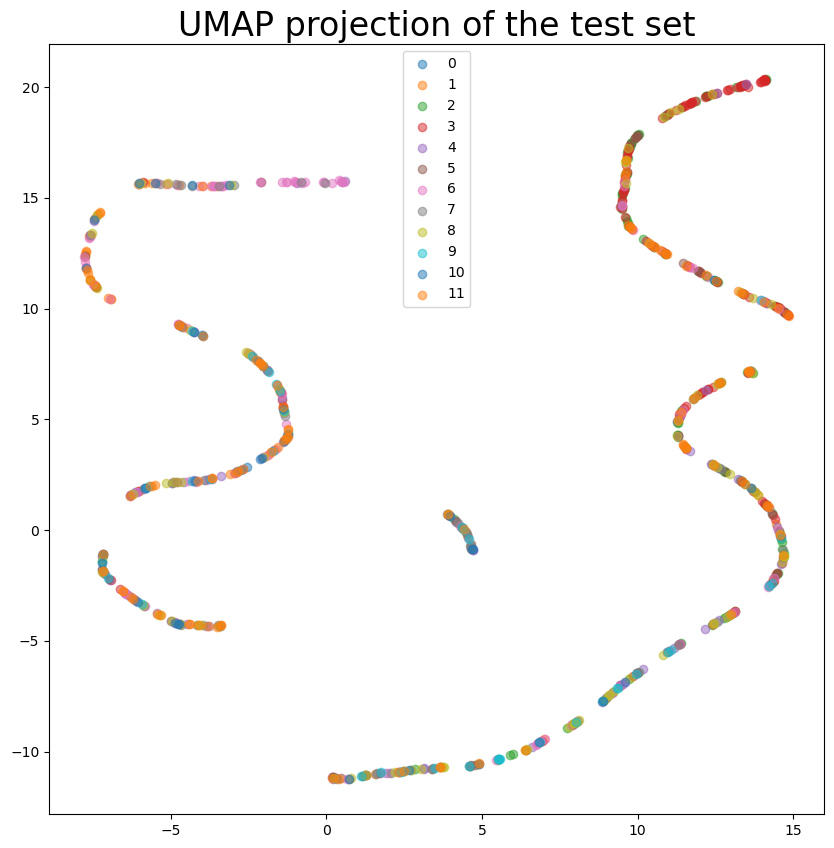

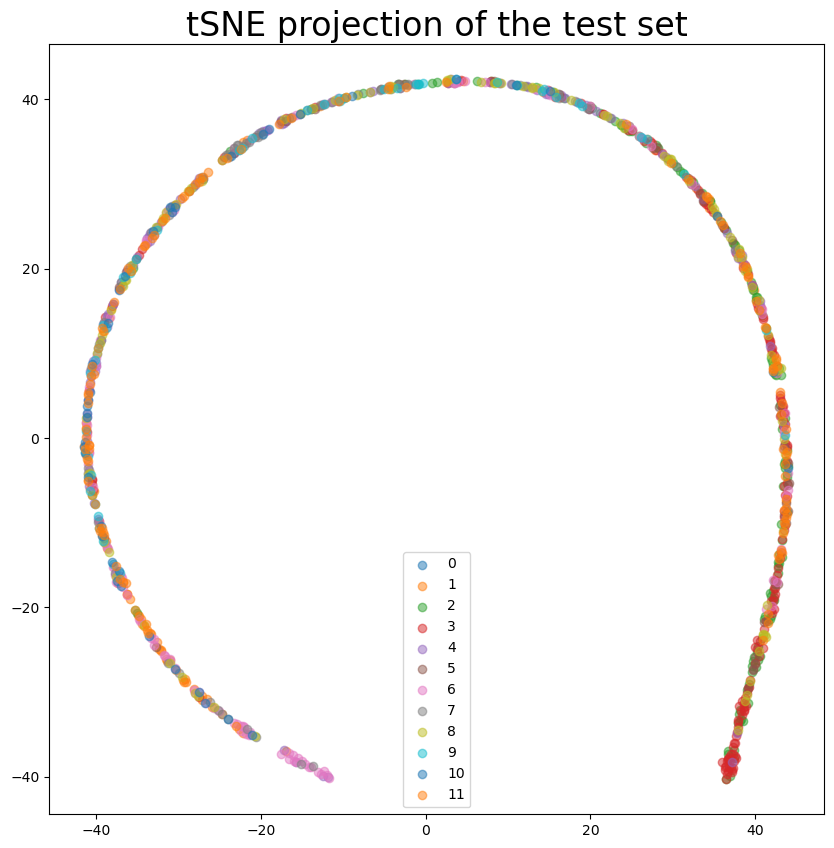

In [19]:
# train_subset_unified = VoxCeleb1IdentificationUnified(train_dataset, present_audio_files = present_train_audio_files)
# train_loader = torch.utils.data.DataLoader(train_subset_unified, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs) # type: ignore

# train_subset_unified = VoxCeleb1IdentificationUnified(train_dataset, present_audio_files = present_train_audio_files[:1024])
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, drop_last=True, **kwargs) # type: ignore

# train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
# plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)